In [18]:
import pandas as pd
import numpy as np

import re
import os
import glob

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm
import torch.optim as optim

from focal_loss.focal_loss import FocalLoss

import matplotlib.pyplot as plt

In [19]:
def aIOU(predictions, gt):
    classes = np.unique(np.concatenate((np.unique(predictions), np.unique(gt))))
    IoUs = np.zeros(len(classes) - 1)
    i = 0
    for cls in classes:
        if cls != 0:
            preds_tmp = predictions == cls
            gt_tmp = gt == cls
            IoUs[i] = np.sum(np.logical_and(preds_tmp, gt_tmp)) / np.sum(np.logical_or(preds_tmp, gt_tmp))
            i += 1
    return np.mean(IoUs)

In [20]:
# UNET

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=2, out_channels=22, features=[40, 80, 160, 320],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        x = torch.softmax(x, dim=1)
        # permute to have channels as last dimension
        return x.permute(0, 2, 3, 1).contiguous()

In [21]:
class MuonDataset(Dataset):
    def __init__(self, directory):
        self.x_files = glob.glob(os.path.join(directory, "*X*.pt"))
        self.x_files.sort(key=lambda f: int(re.sub('\D', '', f)))
        self.y_files = glob.glob(os.path.join(directory, "*y*.pt"))
        self.y_files.sort(key=lambda f: int(re.sub('\D', '', f)))

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, index):
        x_idx = torch.load(self.x_files[index])
        y_idx = torch.load(self.y_files[index])
        return x_idx, y_idx

In [22]:
class MuonTestDataset(Dataset):
    def __init__(self, directory):
        self.x_files = glob.glob(os.path.join(directory, "*X*.pt"))
        self.x_files.sort(key=lambda f: int(re.sub('\D', '', f)))

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, index):
        x_idx = torch.load(self.x_files[index])
        return x_idx

In [23]:
def get_loaders(
    batch_size,
    num_workers=4,
    pin_memory=True,
):
    train_ds = MuonDataset(
        directory="../data/train",
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = MuonDataset(
        directory="../data/val",
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    test_ds = MuonTestDataset(
        directory="../data/test",
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader

In [24]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print device
print(DEVICE)
BATCH_SIZE = 32
NUM_EPOCHS = 4
NUM_WORKERS = 2
PIN_MEMORY = True

cuda


In [25]:

def train_function(data, model, optimizer, loss_fn):
    print('Entering into train function')
    loss_values = []    
    data = tqdm(data)    
    for index, (X, y) in enumerate(data):              
        X, y = X.to(DEVICE), y.to(DEVICE)        
        preds = model(X)  
          
        loss = loss_fn(preds, y)        
        optimizer.zero_grad()        
        loss.backward()        
        optimizer.step()  
   
    return loss.item()

In [26]:
model = UNET(in_channels=2, out_channels=22).to(DEVICE)
loss_fn = FocalLoss(gamma=2)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader, test_loader = get_loaders(
        BATCH_SIZE,
        NUM_WORKERS,
        PIN_MEMORY,
)

In [27]:
for epoch in range(NUM_EPOCHS):
        loss = train_function(train_loader, model, optimizer, loss_fn)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, loss={loss}")

Entering into train function


  0%|          | 87/27000 [00:03<15:28, 29.00it/s] 


KeyboardInterrupt: 

In [ ]:
def output_transform(output):
    # change output to 1D tensor
    # first pick max value for each pixel over channels
    # then flatten to 1d
    output = torch.argmax(output, dim=-1)
    return output.flatten().cpu().numpy()


In [ ]:
def eval():
   # use val_loader
   model.eval()
   with torch.no_grad():
         for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            output = output_transform(output)
            target = target.flatten().cpu().numpy()
            aiou_list = []
            aiou_list.append(aIOU(output, target))
         aIou = np.mean(aiou_list)
         print('IOU: ', aIou)

In [ ]:
eval()

IOU:  0.2116986538995664


In [ ]:
def pred_test():
    model.eval()
    with torch.no_grad():
        result = []
        for batch_idx, (data) in enumerate(test_loader):
            data = data.to(DEVICE)
            output = model(data)
            output = output_transform(output)
            result.append(output)
        return result

In [ ]:
preds = pred_test()
preds_out = np.concatenate(preds, axis=0).reshape(-1, 40, 40)
preds_out = preds_out.transpose(0, 2, 1).reshape(-1, 1600) # permute so that y_values are consecutive
print(preds_out.shape)

(5000, 1600)


In [ ]:
# save preds_out to csv
df = pd.DataFrame(preds_out)
df.to_csv('isect_weight_line_mean_conf_rollaug.csv', index=False, header=False)

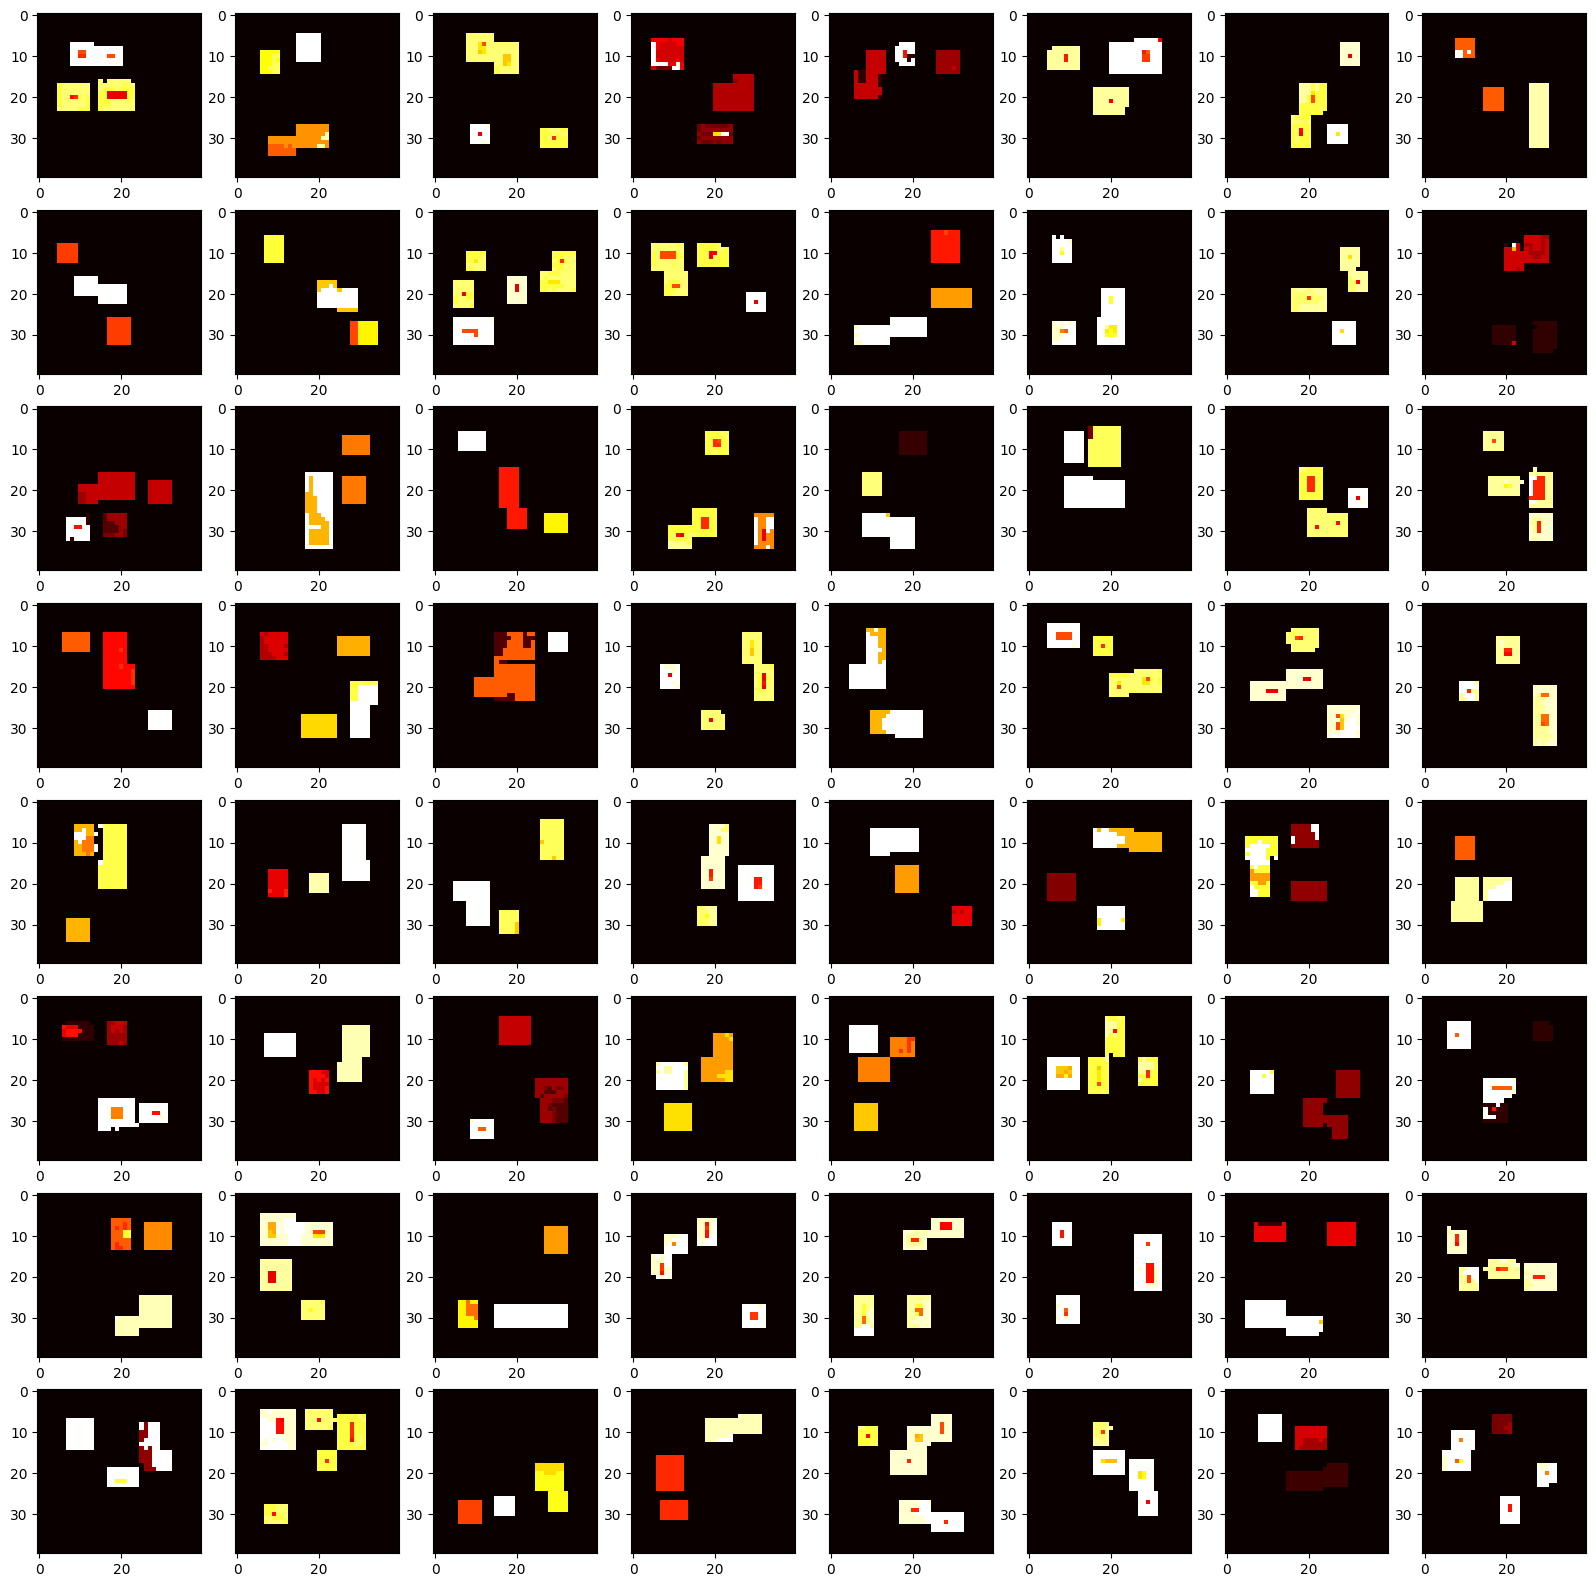

In [ ]:
preds_vis = preds_out.reshape(-1, 40, 40)[:64]

fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(preds_vis[i], cmap='hot', interpolation='nearest')
    # ax.set_title(random_files[i])

plt.show()